In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from glob import glob
import shutil
import os

## 1 get data for all subjects 

#elimination subject number 7 and 11 relating to eeg detect data
#subjecs of 1,3,4,5,6,8,9,10,12,13,14,15,16,17 are remainded

In [2]:
ds_root = "/home/jovyan/hddm/2_Study/2_3_RawData/RawData/Ostwald_OSF/BIDS_data"
anlz_dir = "/home/jovyan/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_subj"
out_MR = "sourcedata-eeg_outside-MRT/beh"
in_MR = "sourcedata-eeg_inside-MRT/beh"

In [3]:
if os.path.exists(anlz_dir):
    shutil.rmtree(anlz_dir)

In [4]:
list_out_subj = ['sub-001', 
                 'sub-003', 
                 'sub-004', 
                 'sub-005', 
                 'sub-006', 
                 'sub-008', 
                 'sub-009', 
                 'sub-010', 
                 'sub-012',
                 'sub-013',
                 'sub-014',
                 'sub-015', 
                 'sub-016',
                 'sub-017']

In [5]:
list_subj = []
list_subj = list_out_subj
folder_MR = out_MR 

In [6]:
for subj in list_subj:
    src_dir_subj = os.path.join(ds_root,subj,folder_MR)
    src_dir_subj = os.path.normpath(src_dir_subj)
    tgt_dir_subj = os.path.join(anlz_dir,subj,folder_MR)
    tgt_dir_subj = os.path.normpath(tgt_dir_subj)
    if not os.path.exists(tgt_dir_subj):
        os.makedirs(tgt_dir_subj)
        
    data = pd.DataFrame({"condition":[],
                     "image_index":[],
                     "key_press":[],
                     "response_time":[],
                     "response_corr":[],
                     "stimulus_side":[],
                     "prioritization_cue":[]})
    
    for subj_beh in glob(src_dir_subj + "/*.tsv"):
        df = pd.read_csv(subj_beh, sep="\t")
        data = pd.concat([data,df], sort=False)
        
    Q1 = data["response_time"].quantile(0.25)
    Q3 = data["response_time"].quantile(0.75)
    IQR = Q3 - Q1
    filterr = (data["response_time"] >= Q1 - 3 * IQR) & (data["response_time"] <= Q3 + 3 * IQR)
    data = data.loc[filterr]
    
    save_file = os.path.join(tgt_dir_subj,subj+".csv")
    
    if not os.path.exists(tgt_dir_subj):
        os.makedirs(tgt_dir_subj)
    data.to_csv(save_file)
    print(subj+" is successfully saved")

sub-001 is successfully saved
sub-003 is successfully saved
sub-004 is successfully saved
sub-005 is successfully saved
sub-006 is successfully saved
sub-008 is successfully saved
sub-009 is successfully saved
sub-010 is successfully saved
sub-012 is successfully saved
sub-013 is successfully saved
sub-014 is successfully saved
sub-015 is successfully saved
sub-016 is successfully saved
sub-017 is successfully saved


## 2 concat data for all filtered subjects

In [7]:
anlz_subj = anlz_dir
anlz_group = "/home/jovyan/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_group"
if os.path.exists(anlz_group):
    shutil.rmtree(anlz_group)

In [8]:
list_subj = list_out_subj
switcher = {'sub-001':1,
            'sub-002':2,
            'sub-003':3,
            'sub-004':4,
            'sub-005':5,
            'sub-006':6,
            'sub-007':7,
            'sub-008':8,
            'sub-009':9,
            'sub-010':10,
            'sub-011':11,
            'sub-012':12,
            'sub-013':13,
            'sub-014':14,
            'sub-015':15,
            'sub-016':16,
            'sub-017':17}
save_file = os.path.join(anlz_group, folder_MR)
if not os.path.exists(save_file):
    os.makedirs(save_file)

In [9]:
data=pd.DataFrame()
for subj_dir in list_subj:
    tgt_dir_subj = os.path.join(anlz_subj, subj_dir, folder_MR, subj_dir + ".csv")
    tgt_dir_subj = os.path.normpath(tgt_dir_subj)
    
    df = pd.read_csv(tgt_dir_subj)
    
    subj_idx = np.zeros(len(df))
    
    stim = np.zeros(len(df))
    
    response = df['key_press'].to_numpy()
    
    rt = df["response_time"].to_numpy()
    
    condition = df["condition"].to_numpy()
    
    response_corr = df['response_corr'].to_numpy()
    
    image_index = df["image_index"].to_numpy()
    
    for i in range(len(df)):
        subj_idx[i] = switcher.get(subj_dir)
        
        if (response_corr[i] == 0):
            if (response[i] == 2):
                stim[i] = 1
            elif (response[i]==1):
                stim[i] = 2
        else:
            stim[i] = response[i]
    df_new = pd.DataFrame(np.column_stack([subj_idx,stim,response,rt,condition,response_corr,image_index]),
                       columns = ['subj_idx','stimulus','response','rt','condition','response_corr', 'image_index'])
    df_new = df_new.loc[np.invert(df_new["rt"].isnull())]
    data = pd.concat([data,df_new], sort=False)
save_file_group=os.path.join(save_file,"group.csv")
data.to_csv(save_file_group)
print("  group is successfully saved\n")

  group is successfully saved



## 3 analysis data

In [10]:
data = pd.read_csv('/home/jovyan/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_group/sourcedata-eeg_outside-MRT/beh/group.csv')
data = data[(data['subj_idx']!=7)&(data['subj_idx']!=11)]

In [11]:
data['coherency'] = data['condition']
data['spatial'] = data['condition']

In [12]:
data['spatial'] = data['spatial'].replace(1,"Yes")
data['spatial'] = data['spatial'].replace(2,"No")
data['spatial'] = data['spatial'].replace(3,"Yes")
data['spatial'] = data['spatial'].replace(4,"No")

In [13]:
data['coherency'] = data['coherency'].replace(1,"High")
data['coherency'] = data['coherency'].replace(2,"High")
data['coherency'] = data['coherency'].replace(3,"Low")
data['coherency'] = data['coherency'].replace(4,"Low")

In [14]:
data['response']=data['response'].replace(1,0)
data['response']=data['response'].replace(2,1)

In [15]:
data['stimulus']=data['stimulus'].replace(1,0)
data['stimulus']=data['stimulus'].replace(2,1)

In [16]:
performance_data = pd.DataFrame({'ACC':[],
                                'RT':[],
                                'Condition':[],
                                'Subject':[],
                                'Stimulus':[]})
for i in range(1,18):
    if i !=2 and i != 7 and i != 11:
        select_subject = i
        data1 = data[data['subj_idx'] == select_subject]
        
        data_High_Yes_1 = data1[(data1["coherency"]=="High")&(data1["spatial"]=="Yes")&(data1["stimulus"]==1)]
        data_High_Yes_1 = data1[(data1['coherency']=='High')&(data1['spatial']=='Yes')&(data1['stimulus']==1)]
        data_High_Yes_0 = data1[(data1['coherency']=='High')&(data1['spatial']=='Yes')&(data1['stimulus']==0)]
        data_High_No_1  = data1[(data1['coherency']=='High')&(data1['spatial']=='No')&(data1['stimulus'] ==1)]
        data_High_No_0  = data1[(data1['coherency']=='High')&(data1['spatial']=='No')&(data1['stimulus'] ==0)]
        data_Low_Yes_1  = data1[(data1['coherency']=='Low')&(data1['spatial'] =='Yes')&(data1['stimulus']==1)]
        data_Low_Yes_0  = data1[(data1['coherency']=='Low')&(data1['spatial'] =='Yes')&(data1['stimulus']==0)]
        data_Low_No_1   = data1[(data1['coherency']=='Low')&(data1['spatial'] =='No')&(data1['stimulus'] ==1)]
        data_Low_No_0   = data1[(data1['coherency']=='Low')&(data1['spatial'] =='No')&(data1['stimulus'] ==0)]
        
        data_rt_High_Yes_1_mean = np.mean(data_High_Yes_1['rt'])
        data_rt_High_Yes_0_mean = np.mean(data_High_Yes_0['rt']) 
        data_rt_High_No_1_mean  = np.mean(data_High_No_1['rt'])
        data_rt_High_No_0_mean  = np.mean(data_High_No_0['rt']) 
        data_rt_Low_Yes_1_mean  = np.mean(data_Low_Yes_1['rt']) 
        data_rt_Low_Yes_0_mean  = np.mean(data_Low_Yes_0['rt'])
        data_rt_Low_No_1_mean   = np.mean(data_Low_No_1['rt'])
        data_rt_Low_No_0_mean   = np.mean(data_Low_No_0['rt'])
        
        data_acc_High_Yes_1_mean = float(np.sum(data_High_Yes_1['response']==1))/len(data_High_Yes_1)
        data_acc_High_Yes_0_mean = float(np.sum(data_High_Yes_0['response']==0))/len(data_High_Yes_0)
        data_acc_High_No_1_mean  = float(np.sum(data_High_No_1['response']==1))/len(data_High_No_1)
        data_acc_High_No_0_mean  = float(np.sum(data_High_No_0['response']==0))/len(data_High_No_0)
        data_acc_Low_Yes_1_mean  = float(np.sum(data_Low_Yes_1['response']==1))/len(data_Low_Yes_1)
        data_acc_Low_Yes_0_mean  = float(np.sum(data_Low_Yes_0['response']==0))/len(data_Low_Yes_0)
        data_acc_Low_No_1_mean   = float(np.sum(data_Low_No_1['response']==1))/len(data_Low_No_1)
        data_acc_Low_No_0_mean   = float(np.sum(data_Low_No_0['response']==0))/len(data_Low_No_0)
        
        data_new = pd.DataFrame({'ACC' : [data_acc_High_Yes_1_mean*100, data_acc_High_Yes_0_mean*100, data_acc_High_No_1_mean*100,
                                             data_acc_High_No_0_mean*100, data_acc_Low_Yes_1_mean*100, data_acc_Low_Yes_0_mean*100,
                                            data_acc_Low_No_1_mean*100, data_acc_Low_No_0_mean*100],
                                     'RT': [data_rt_High_Yes_1_mean*1000, data_rt_High_Yes_0_mean*1000, data_rt_High_No_1_mean*1000,
                                             data_rt_High_No_0_mean*1000, data_rt_Low_Yes_1_mean*1000, data_rt_Low_Yes_0_mean*1000,
                                            data_rt_Low_No_1_mean*1000, data_rt_Low_No_0_mean*1000],
                                     'Condition' : ['High/Yes', 'High/Yes', 'High/No',
                                                    'High/No', 'Low/Yes', 'Low/Yes',
                                                    'Low/No', 'Low/No'],
                                     'Subject' : [select_subject,select_subject,select_subject,
                                                 select_subject,select_subject,select_subject,
                                                 select_subject,select_subject],
                                     'Stimulus' : ['Face','Car','Face',
                                                   'Car','Face','Car',
                                                   'Face','Car']})
        performance_data = performance_data.append(data_new)
performance_data['Subject'] = performance_data['Subject'].astype(int)        

In [17]:
data.to_csv('/home/jovyan/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_group/sourcedata-eeg_outside-MRT/beh/preprocessed_group.csv')
performance_data.to_csv('/home/jovyan/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_group/sourcedata-eeg_outside-MRT/beh/performance_data.csv')

In [18]:
SEM_RT = np.array([
performance_data[(performance_data['Condition']=='High/Yes')&(performance_data['Stimulus']=='Car')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='High/Yes')&(performance_data['Stimulus']=='Face')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='High/No')&(performance_data['Stimulus']=='Car')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='High/No')&(performance_data['Stimulus']=='Face')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='Low/Yes')&(performance_data['Stimulus']=='Car')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='Low/Yes')&(performance_data['Stimulus']=='Face')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='Low/No')&(performance_data['Stimulus']=='Car')]['RT'].std(axis=0)/np.sqrt(14),
performance_data[(performance_data['Condition']=='Low/No')&(performance_data['Stimulus']=='Face')]['RT'].std(axis=0)/np.sqrt(14)])

In [19]:
SEM_ACC = np.array([
performance_data[(performance_data['Condition']=='High/Yes')&(performance_data['Stimulus']=="Car")]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='High/Yes')&(performance_data['Stimulus']=='Face')]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='High/No')&(performance_data['Stimulus']=='Car')]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='High/No')&(performance_data['Stimulus']=='Face')]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='Low/Yes')&(performance_data['Stimulus']=='Car')]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='Low/Yes')&(performance_data['Stimulus']=='Face')]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='Low/No')&(performance_data['Stimulus']=='Car')]['ACC'].std(axis=0)/np.sqrt(1),
performance_data[(performance_data['Condition']=='Low/No')&(performance_data['Stimulus']=='Face')]['ACC'].std(axis=0)/np.sqrt(1)])

In [29]:
model_aovrm2way = AnovaRM(data,
                   'response_corr',
                   'subj_idx',
                   within=['coherency','spatial','stimulus'],
                   aggregate_func='mean')
res2way=model_aovrm2way.fit()
print(res2way)

                         Anova
                           F Value Num DF  Den DF Pr > F
--------------------------------------------------------
coherency                  41.8359 1.0000 13.0000 0.0000
spatial                     2.1203 1.0000 13.0000 0.1691
stimulus                    0.8486 1.0000 13.0000 0.3737
coherency:spatial           0.0567 1.0000 13.0000 0.8155
coherency:stimulus          0.1352 1.0000 13.0000 0.7191
spatial:stimulus            2.9243 1.0000 13.0000 0.1110
coherency:spatial:stimulus  0.3312 1.0000 13.0000 0.5748



In [30]:
model_aovrm2way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherency','spatial','stimulus'],
                   aggregate_func='mean')
res2way=model_aovrm2way.fit()
print(res2way)

                         Anova
                           F Value Num DF  Den DF Pr > F
--------------------------------------------------------
coherency                  38.2801 1.0000 13.0000 0.0000
spatial                    11.8352 1.0000 13.0000 0.0044
stimulus                    0.7812 1.0000 13.0000 0.3928
coherency:spatial           0.5443 1.0000 13.0000 0.4738
coherency:stimulus          8.5489 1.0000 13.0000 0.0119
spatial:stimulus            0.1368 1.0000 13.0000 0.7174
coherency:spatial:stimulus  0.7477 1.0000 13.0000 0.4029



/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1529: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ci == "sd":


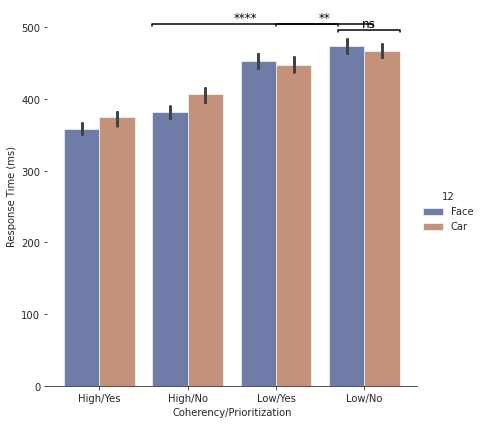

In [44]:
g = sns.catplot(
    data=performance_data,
    kind="bar",
    x="Condition",
    y="RT",
    hue="Stimulus",
    ci=SEM_RT,
    palette="dark",
    alpha=0.6,
    height=6,
    hue_order=['Face','Car'])
g.despine(left=True)
g.set_axis_labels(
    "Coherency/Prioritization",
    "Response Time (ms)")
g.legend.set_title("12")

x1,x2 = 2.7,3.4   #stimulus
y,h,col = 492 + 2, 2, 'k'
plt.plot(
    [x1,x1,x2,x2],
    [y,y+h,y+h,y],
    lw=1.5, 
    c=col)
plt.text(
    (x1+x2)*0.5, 
    y+h, 
    "ns",
    ha='center',
    va='bottom',
    color=col,
    fontsize=12)

x1,x2 = 2,3.1   #spatial
y, h, col =500+2, 2, 'k' 
plt.plot(
    [x1,x1,x2,x2],
    [y,y+h,y+h,y],
    lw=1.5, 
    c=col)
plt.text(
    (x1+x2)*0.5, 
    y+h, 
    "**",
    ha='center',
    va='bottom',
    color=col,
    fontsize=12)

x1, x2 = 0.6, 2.7   # coherency
y, h, col = 500 + 2, 2, 'k'
plt.plot(
    [x1,x1,x2,x2], 
    [y,y+h,y+h,y], 
    lw=1.5, 
    c=col)
plt.text(
    (x1+x2)*.5, 
    y+h, 
    "****", 
    ha='center', 
    va='bottom', 
    color=col, 
    fontsize=12)
plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1529: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ci == "sd":


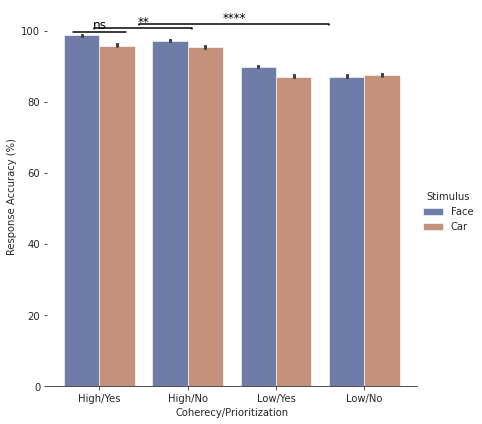

In [22]:
sns.set_style(style="ticks")
g = sns.catplot(
    data=performance_data, 
    kind="bar",
    x="Condition", 
    y="ACC", 
    hue="Stimulus",
    ci=SEM_ACC, 
    palette="dark", 
    alpha=.6, 
    height=6, 
    hue_order=['Face','Car'])
g.despine(left=True)
g.set_axis_labels(
        "Coherecy/Prioritization", 
        "Response Accuracy (%)")
#g.legend.set_title("12")
x1, x2 = -.3, 0.3   # stimulus
y, h, col = 99.5, 0.2, 'k'
plt.plot([x1, x1, x2, x2], 
         [y, y+h, y+h, y], 
         lw=1.5, 
         c=col)
plt.text(
    (x1+x2)*0.5, 
    y+h, 
    "ns",
    ha='center',
    va='bottom',
    color=col,
    fontsize=12)
x1, x2 = -.06, 1.05   # spatial
y, h, col = 100.5, 0.2, 'k'
plt.plot([x1, x1, x2, x2], 
         [y, y+h, y+h, y], 
         lw=1.5, 
         c=col)
plt.text(
    (x1+x2)*0.5, 
    y+h, 
    "**",
    ha='center',
    va='bottom',
    color=col,
    fontsize=12)


x1, x2 = 0.45, 2.6   # coherency
y, h, col = 101.5, 0.2, 'k'
plt.plot([x1, x1, x2, x2], 
         [y, y+h, y+h, y], 
         lw=1.5, 
         c=col)
plt.text(
    (x1+x2)*0.5, 
    y+h, 
    "****",
    ha='center',
    va='bottom',
    color=col,
    fontsize=12)
plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'RT(ms)')

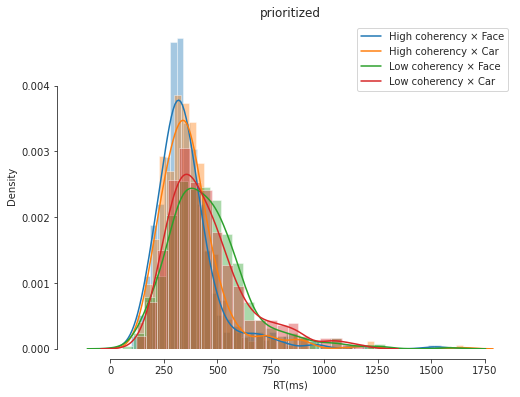

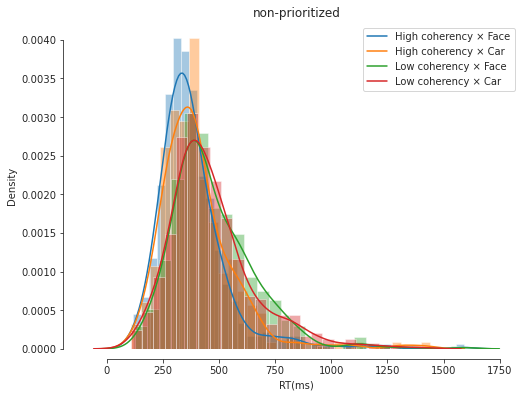

In [43]:
plt.figure(figsize=(8,6))
# high coherence and prioritized 
sns.distplot(data[(data['coherency']=='High')&
                      (data['spatial']=='Yes')&
                      (data['stimulus']==1)]['rt'].to_numpy()*1000, 
             label='HF')
sns.distplot(data[(data['coherency']=='High')&
                      (data['spatial']=='Yes')&
                      (data['stimulus']==0)]['rt'].to_numpy()*1000, 
             label='HC')
# Low coherence and prioritized 
sns.distplot(data[(data['coherency']=='Low')&
                      (data['spatial']=='Yes')&
                      (data['stimulus']==1)]['rt'].to_numpy()*1000, 
             label='LF')
sns.distplot(data[(data['coherency']=='Low')&
                      (data['spatial']=='Yes')&
                      (data['stimulus']==0)]['rt'].to_numpy()*1000, 
             label='LC')
sns.despine(offset=10, trim=True)
plt.legend(labels=['High coherency × Face',
                   'High coherency × Car',
                   'Low coherency × Face', 
                   'Low coherency × Car'])
plt.title("prioritized")
plt.xlabel("RT(ms)")
plt.savefig('/home/jovyan/hddm/RT1.png')



#plor bahavioral data (RT distribution prioritized)
plt.figure(figsize=(8,6))
    # high coherence and non-prioritized 
sns.distplot(data[(data['coherency']=='High')&
                      (data['spatial']=='No')&
                      (data['stimulus']==1)]['rt'].to_numpy()*1000, 
             label='HF')
sns.distplot(data[(data['coherency']=='High')&
                      (data['spatial']=='No')&
                      (data['stimulus']==0)]['rt'].to_numpy()*1000, 
             label='HC')
    # Low coherence and Non-prioritized 
sns.distplot(data[(data['coherency']=='Low')&
                      (data['spatial']=='No')&
                      (data['stimulus']==1)]['rt'].to_numpy()*1000, 
             label='LF')

sns.distplot(data[(data['coherency']=='Low')&
                      (data['spatial']=='No')&
                      (data['stimulus']==0)]['rt'].to_numpy()*1000, 
             label='LC')
sns.despine(offset=10, trim=True);
plt.legend(labels=['High coherency × Face',
                   'High coherency × Car',
                   'Low coherency × Face', 
                   'Low coherency × Car'])
plt.title("non-prioritized")
plt.xlabel("RT(ms)")

In [45]:
pdata = pd.read_csv("~/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_group/sourcedata-eeg_outside-MRT/beh/performance_data.csv")

In [46]:
diff_data = pd.DataFrame({'ACC_high':[],
                          'ACC_low':[],
                          'RT_high':[],
                          'RT_low':[],
                          'diff_acc':[],
                          'diff_rt':[],
                          'Subject':[]})
for i in range(1,18):
    if i !=2 and i != 7 and i != 11:
        subject = i
        
        data_High = pdata[(pdata["Condition"]=="High/Yes")|(pdata["Condition"]=="High/No")&(pdata["Subject"]==i)]
        data_Low = pdata[(pdata["Condition"]=="Low/Yes")|(pdata["Condition"]=="Low/No")&(pdata["Subject"]==i)]
        
        data_High_rt = data_High['RT'].mean()
        data_Low_rt = data_Low['RT'].mean()
        data_diff_rt = data_High_rt - data_Low_rt
        
        data_High_acc = data_High['ACC'].mean()
        data_Low_acc = data_Low['ACC'].mean()
        data_diff_acc = data_High_acc - data_Low_acc
        
        data_new = pd.DataFrame({'ACC_high':[ data_High_acc],
                          'ACC_low':[data_Low_acc],
                          'RT_high':[data_High_rt],
                          'RT_low':[data_Low_rt],
                          'diff_acc':[data_diff_acc],
                          'diff_rt':[data_diff_rt],
                          'Subject':[i]})
        diff_data = diff_data.append(data_new)
diff_data['Subject'] = diff_data['Subject'].astype(int) 

In [47]:
diff_data.to_csv("~/hddm/2_Study/2_4_Analysis/2_4_3_tmp_data/filtered_group/sourcedata-eeg_outside-MRT/beh/diff_data.csv",index = False)